# Analyze how FTT date relates to FTU and sign-up dates for direct merchants

Проанализировать paid accounts на 1.03.2022 on Direct channel.

     Часть 1:
    Как соотносятся между собой:
    FTT и sign up
    FTT и FTU
    FTU и sign up
    Часть 2:    
    Посмотреть есть ли какие-то тенденции по:
    страны. Выбрать топ 10 стран по кол-ву paid accounts

In [2]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
from IPython.display import display
import plotly.express as px 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from pandas.plotting import scatter_matrix
import math
#import random
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")


import requests
import re
from datetime import datetime
%matplotlib inline

In [3]:
# Вывод всех строк таблицы на экран
from IPython.display import display
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_colwidth', None)
pd.options.display.max_rows = 50

### Заливка данных

In [4]:
from io import BytesIO
import requests

spreadsheet_id = '91vZqZJO75r9UfwVSBNjxOArUBG_9vUkE3iYVU3eY1hmQ'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)

df_raw = pd.read_csv(BytesIO(r.content), parse_dates=['fttu_date', 'signup_period', 'ftu_date', 'registered'])
df_raw.head()

In [6]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55022 entries, 0 to 55021
Data columns (total 48 columns):
 #   Column                                       Non-Null Count  Dtype         
---  ------                                       --------------  -----         
 0   check_date                                   55022 non-null  object        
 1   store_id                                     55022 non-null  int64         
 2   email                                        55022 non-null  object        
 3   store_url                                    53050 non-null  object        
 4   registered                                   55022 non-null  datetime64[ns]
 5   ownername                                    55022 non-null  object        
 6   channel_type                                 55022 non-null  object        
 7   channel_id                                   55022 non-null  object        
 8   plan_id_at_check_date                        55022 non-null  object        


In [7]:
df_raw['store_id'].nunique()

55022

## Обработка данных

In [8]:
#Считаем сколько в среднем % составляют пропуски по столбцам
pd.DataFrame(round((df_raw.isna().mean()*100),2)).style.background_gradient('coolwarm')

,0
check_date,0.000000
store_id,0.000000
email,0.000000
store_url,3.580000
registered,0.000000
ownername,0.000000
channel_type,0.000000
channel_id,0.000000
plan_id_at_check_date,0.000000
plan_title_at_check_date,0.000000


In [5]:
# Беру нужные столбцы
df = df_raw[['store_id', \
             'registered', \
             'fttu_date', \
             'ftu_date', \
             'signup_period', \
             'office_countrycode', \
            'gmv__120d (at current date)', \
            'gmv__30d (at current date)', \
            'n_orders__120d (at current date)', \
            'n_orders__30d (at current date)' \
             
            ]].copy().rename(columns={'office_countrycode': 'country', \
                                    'gmv__120d (at current date)' : 'gmv_120d', \
                                    'gmv__30d (at current date)' : 'gmv_30d', \
                                    'n_orders__120d (at current date)': 'n_orders_120d', \
                                    'n_orders__30d (at current date)': 'n_orders_30d',})

#df.head()

In [6]:
# Убираю часы и минуты из дат
df['fttu_date'] = df['fttu_date'].dt.date
df['ftu_date'] = df['ftu_date'].dt.date
df['registered'] = df['registered'].dt.date


In [7]:
# Убираю строки где FTTU NAN
df_fttu_reg = df[df['fttu_date'].notna()]
#df_fttu_reg.head()

In [8]:
# Считаю разницу
df_fttu_reg['fttu_reg'] = df_fttu_reg['fttu_date'] - df_fttu_reg['registered']
df_fttu_reg['fttu_ftu'] = df_fttu_reg['fttu_date'] - df_fttu_reg['ftu_date']
df['ftu_reg'] = df['ftu_date'] - df['registered']

In [9]:
# Убираю слова days
df_fttu_reg['fttu_reg'] = df_fttu_reg['fttu_reg'].dt.days
df_fttu_reg['fttu_ftu'] =df_fttu_reg['fttu_ftu'].dt.days
df['ftu_reg'] = df['ftu_reg'].dt.days

#df.head()

## Расчетная часть

In [14]:
# Выбираю top 10 стран
country_df = df.pivot_table(index='country', \
                            values='store_id', \
                            aggfunc='nunique') \
.reset_index() \
.sort_values('store_id', ascending=False) \
.rename(columns={'store_id': 'n_stores'}).head(10)

country_list = country_df['country'].tolist()
country_list

['US', 'GB', 'RU', 'CA', 'AU', 'IT', 'ZA', 'DE', 'FR', 'IN']

In [22]:
df.describe()

### Часть 1. FTTU-registration

In [16]:
print('Среднее количество дней по fttu - registered', round(df_fttu_reg['fttu_reg'].mean()), 'дней')
print()
print('Медиана дней по fttu - registered', round(df_fttu_reg['fttu_reg'].median()), 'дней')
print()

Среднее количество дней по fttu - registered 126 дней

Медиана дней по fttu - registered 33 дней



In [17]:
# функция по boxplot
def boxplots_before(df, x1, x2):
    sns.boxplot(data=df, x=x1)
    plt.title(f'Difference {x2}')
    plt.xlim(0,800)
    plt.show()

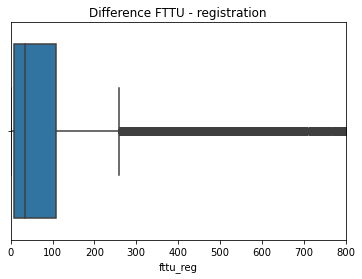

In [18]:
boxplots_before(df_fttu_reg, 'fttu_reg', 'FTTU - registration')

In [19]:
df_fttu_reg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40805 entries, 0 to 50890
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   store_id       40805 non-null  int64         
 1   registered     40805 non-null  object        
 2   fttu_date      40805 non-null  object        
 3   ftu_date       40805 non-null  object        
 4   signup_period  40805 non-null  datetime64[ns]
 5   country        40794 non-null  object        
 6   gmv_120d       40805 non-null  float64       
 7   gmv_30d        40805 non-null  float64       
 8   n_orders_120d  40805 non-null  int64         
 9   n_orders_30d   40805 non-null  int64         
 10  fttu_reg       40805 non-null  int64         
 11  fttu_ftu       40805 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(5), object(4)
memory usage: 4.0+ MB


In [14]:
df_fttu_reg.describe()

In [57]:
def hists(df, x1, x2):
    plt.figure(figsize=(15,7))
    sns.histplot(x=df[x1])
    plt.ylim(0)
    plt.xlim(0,200)
    plt.title(f'{x2}')
    plt.show()

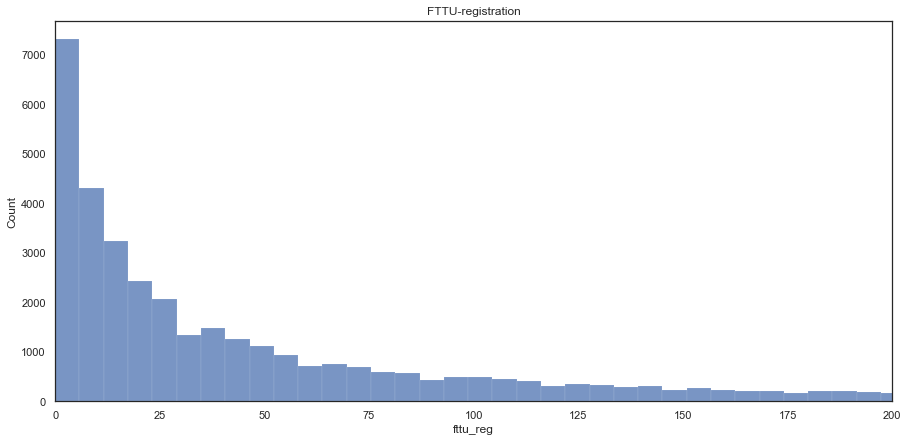

In [58]:
hists(df_fttu_reg, 'fttu_reg', 'FTTU-registration')

### Country FTTU - reg

In [23]:
def df_country(df, x1, x2):
    for value in country_list:
        df1 = df.query('country == @value')
        hists(df1, x1, f'{x2} {value}')

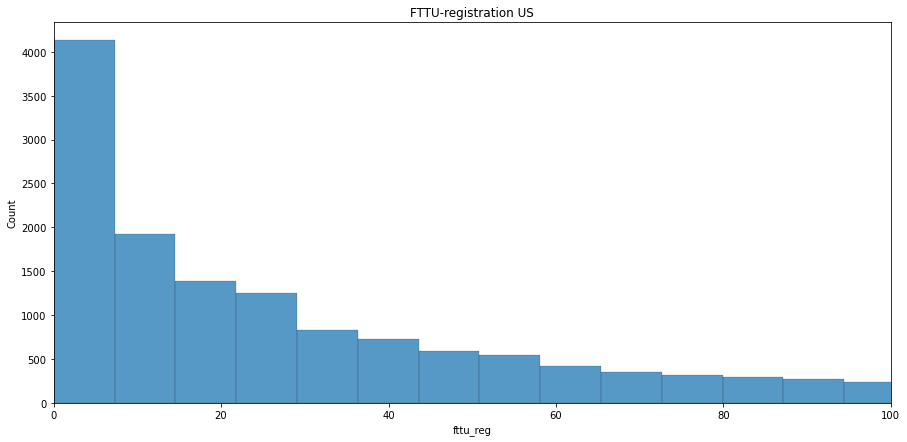

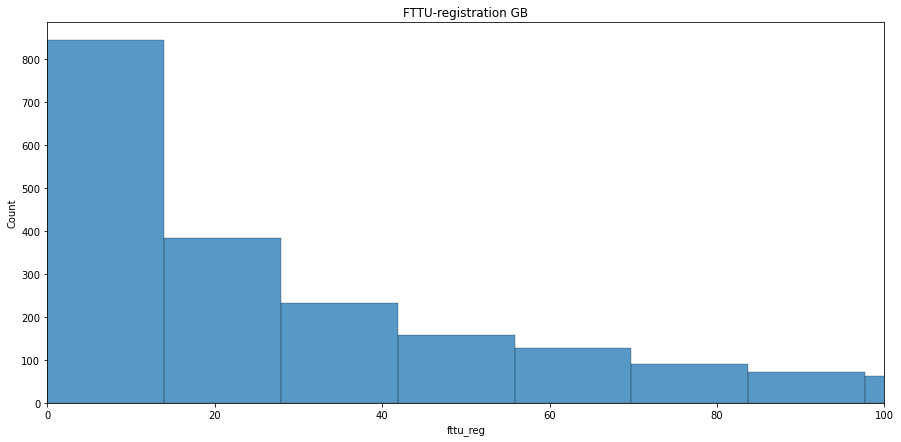

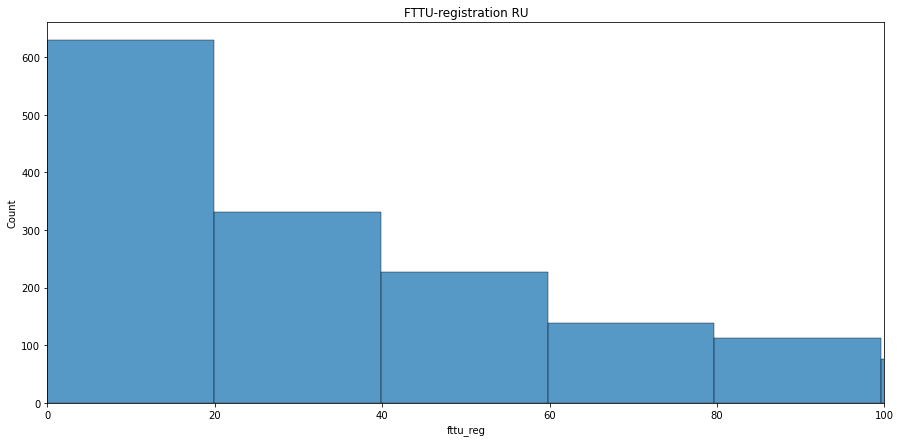

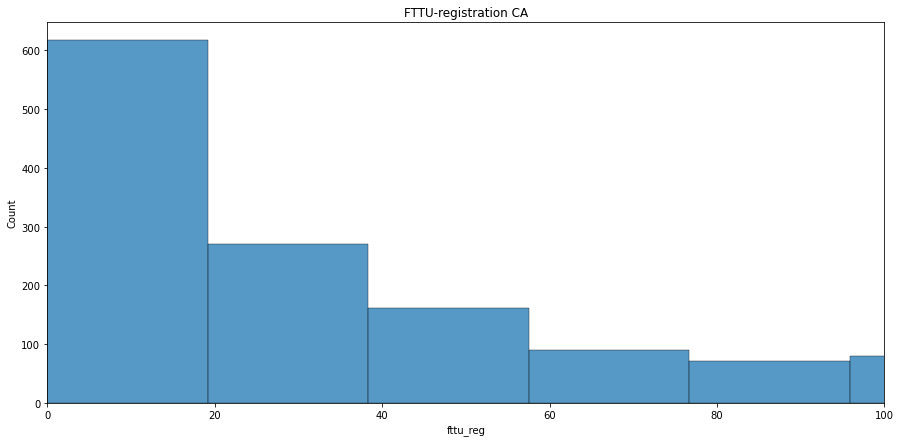

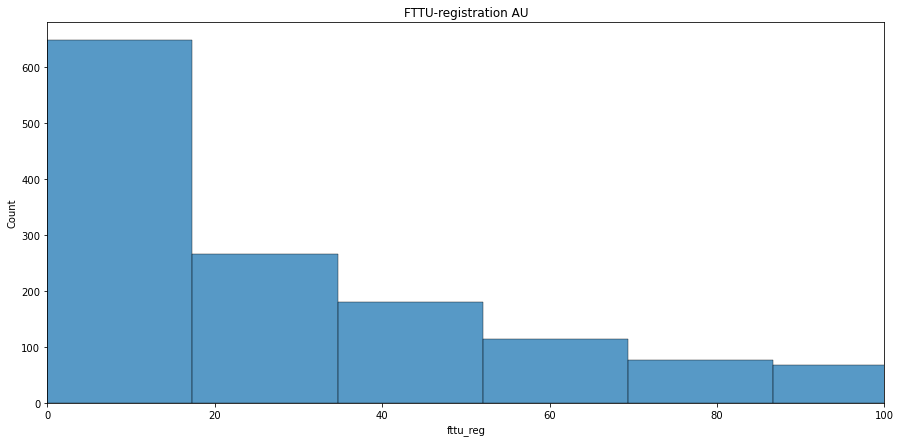

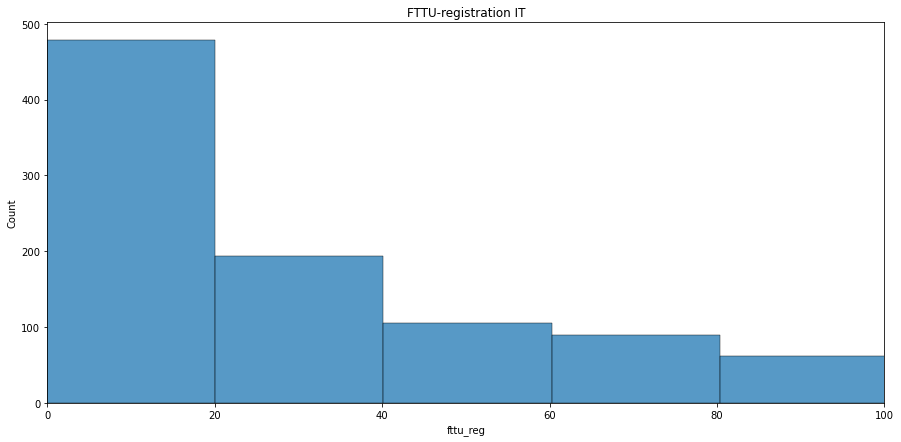

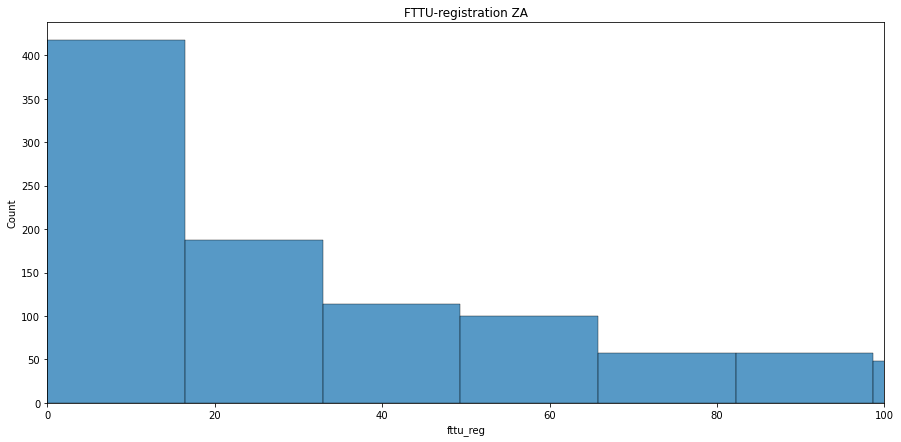

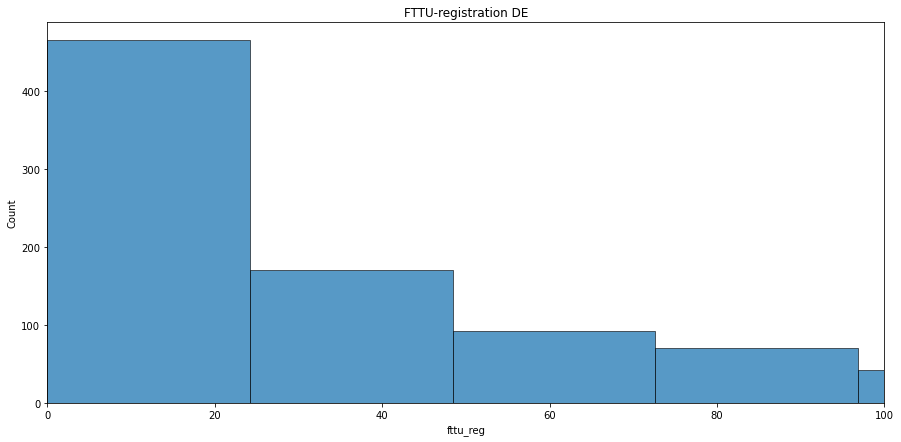

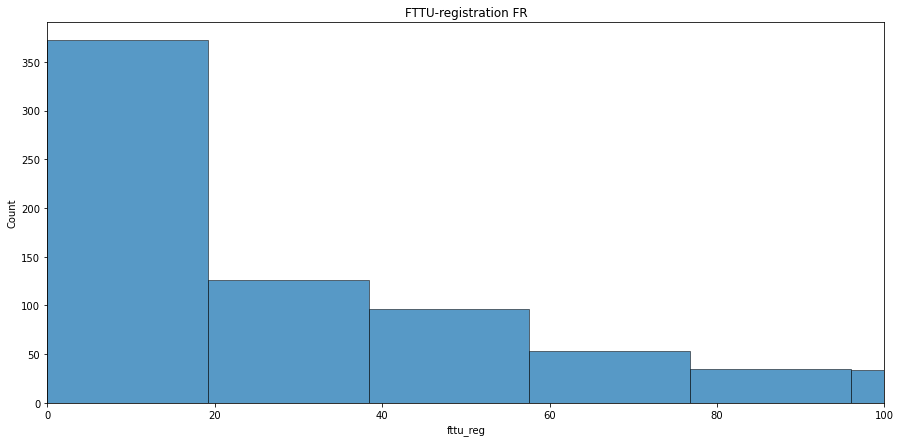

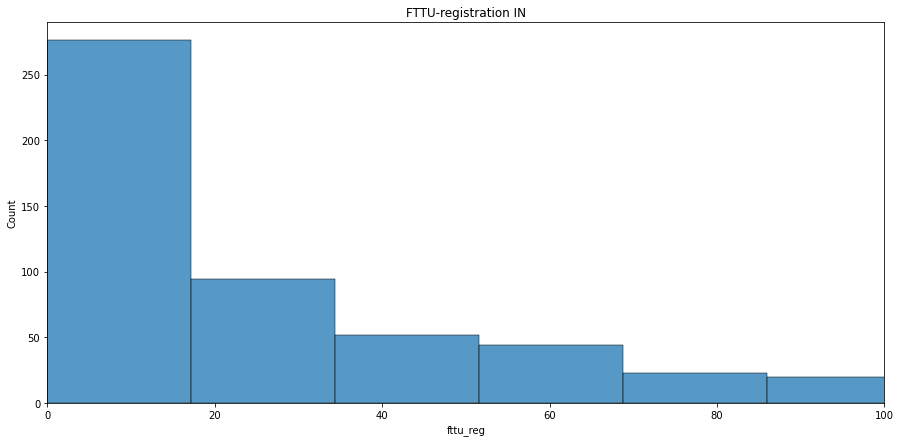

In [24]:
df_country(df_fttu_reg,'fttu_reg', 'FTTU-registration' )

In [10]:
def country_df(df, x1, x2):
    df1 = df.query('country in @country_list')
    for value in country_list:
        df2 = df1.query('country == @value')
        
        print(f'Среднее по {value} = {df2[x1].mean()} дня по {x2}')
        print()
        print(f'Медиана по {value} = {df2[x1].median()} дня по {x2}')
        print()
        print()

In [ ]:
country_df(df_fttu_reg, 'fttu_reg', 'FTTU-registration' )

### Категоризация по FTTU-reg

In [12]:
def category(df, x1, x2, x3):
    df[x1] = pd.cut(df[x2], \
    [-1, 10, 30, 60, 90, 180, 365, 10000], \
    labels = ['less than 10 days', \
          '10-30 days', \
          '30-60 days', \
          '60-90 days', \
          '90-180 days', \
          '180-365 days', \
          'more than 365 days'])
    return df
    

In [13]:
fttu_reg_cat = category(df_fttu_reg,'fttu_reg_categorical','fttu_reg', 'FTTU-reg')
fttu_reg_cat.head()

In [29]:
def graphs(df, x1, x2):
    df1 = df[x1].value_counts().reset_index().rename(columns={'index': 'category'})
    plt.figure(figsize=(15,7))
    sns.barplot(data=df1, x='category', y=x1)
    plt.xticks(rotation = 45)
    plt.title(f'{x2} by categories')
    plt.show()

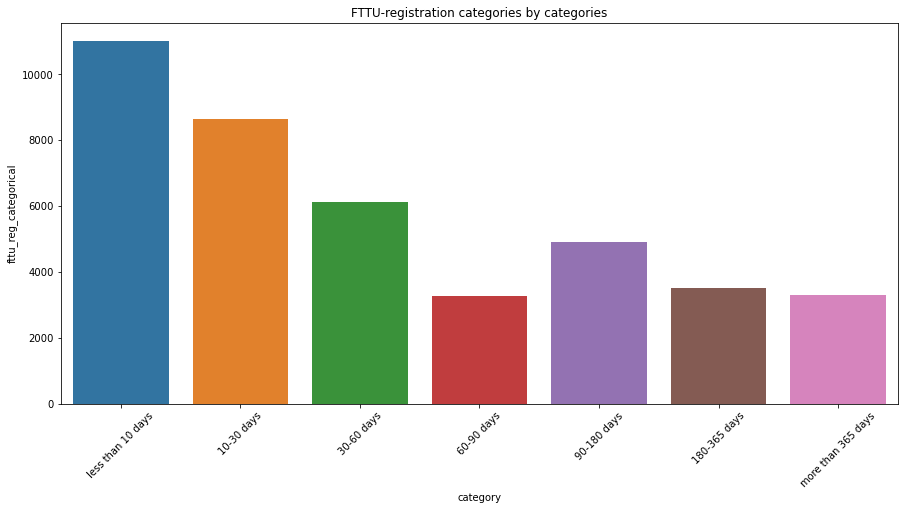

In [30]:
graphs(fttu_reg_cat, 'fttu_reg_categorical', 'FTTU-registration categories')

## Часть 2. FTTU-FTU

In [31]:
print('Среднее количество дней по ftu - fttu', round(df_fttu_reg['fttu_ftu'].mean()), 'дней')
print()
print('Медиана дней по ftu - fttu', round(df_fttu_reg['fttu_ftu'].median()), 'дней')
print()

Среднее количество дней по ftu - fttu 8 дней

Медиана дней по ftu - fttu 11 дней



Разделим fttu_ftu на 2 группы: 1.> 0 те, сначала upgrade, потом продавали 2.< 0 те, кто продавать начал раньше, чем upgrade

In [32]:
fttu_ftu_upgrade = df_fttu_reg.query('fttu_ftu < 0')
fttu_ftu_transact = df_fttu_reg.query('fttu_ftu > 0')

In [33]:
# Для упрощения расчетов в группе upgrade беру модуль, и в дальнейшем difference считаем положительной**
fttu_ftu_upgrade['fttu_ftu'] = fttu_ftu_upgrade['fttu_ftu'].abs()

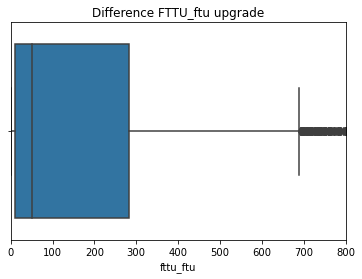

In [34]:
boxplots_before(fttu_ftu_upgrade, 'fttu_ftu', 'FTTU_ftu upgrade')

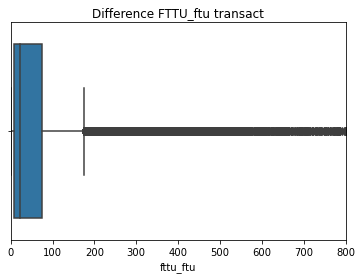

In [35]:
boxplots_before(fttu_ftu_transact, 'fttu_ftu', 'FTTU_ftu transact')

In [15]:
fttu_ftu_upgrade.describe()

In [16]:
fttu_ftu_transact.describe()

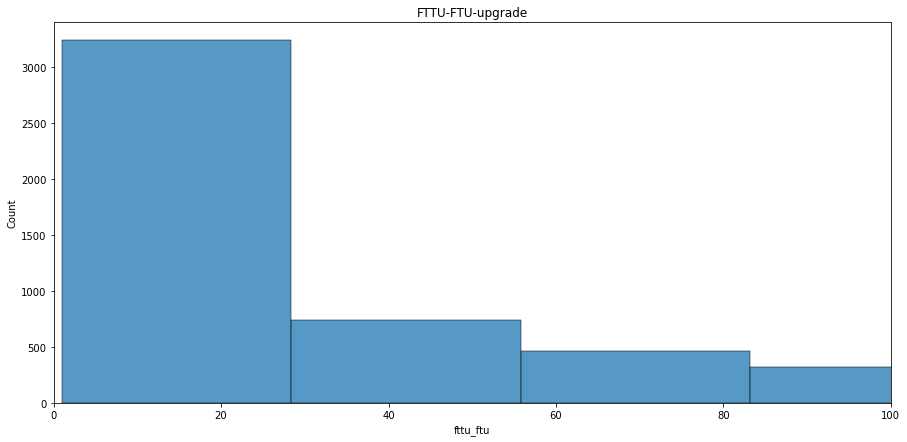

In [38]:
hists(fttu_ftu_upgrade, 'fttu_ftu', 'FTTU-FTU-upgrade')

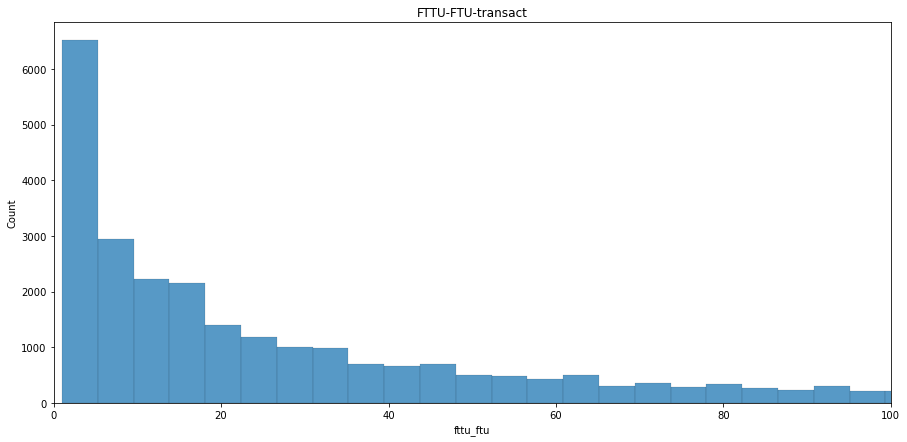

In [39]:
hists(fttu_ftu_transact, 'fttu_ftu', 'FTTU-FTU-transact')

### FTTU-FTU по странам

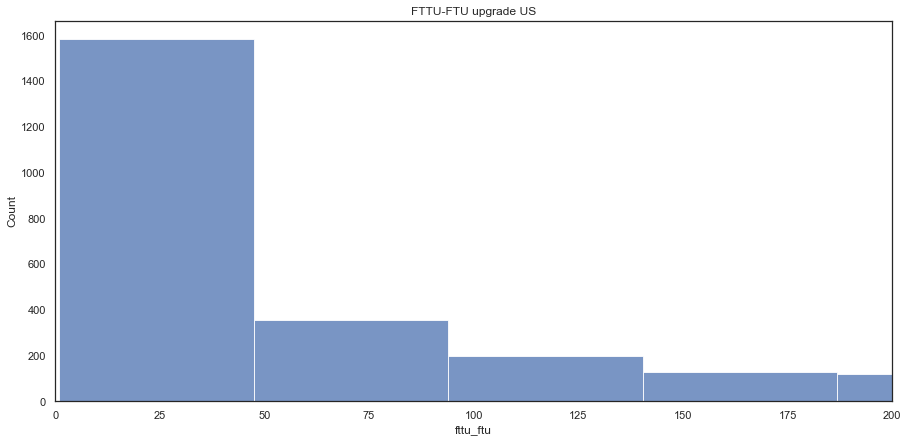

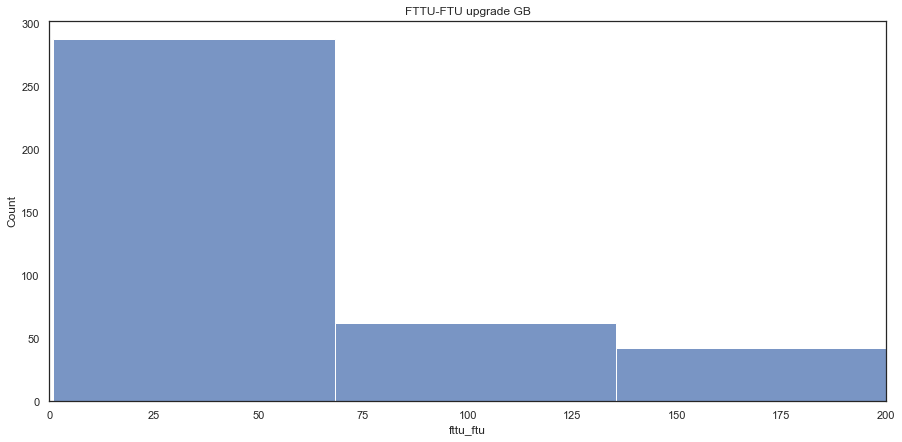

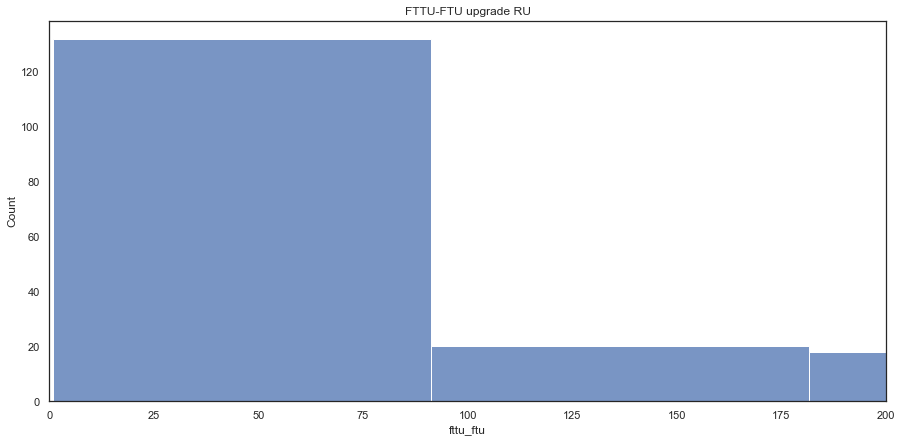

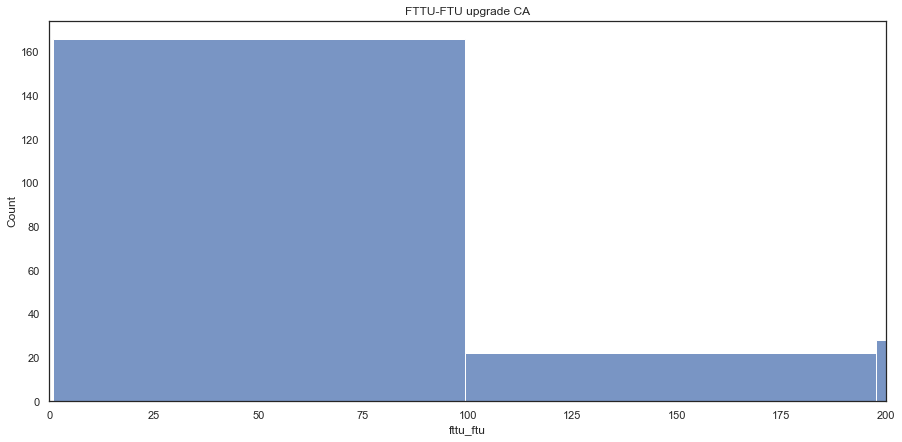

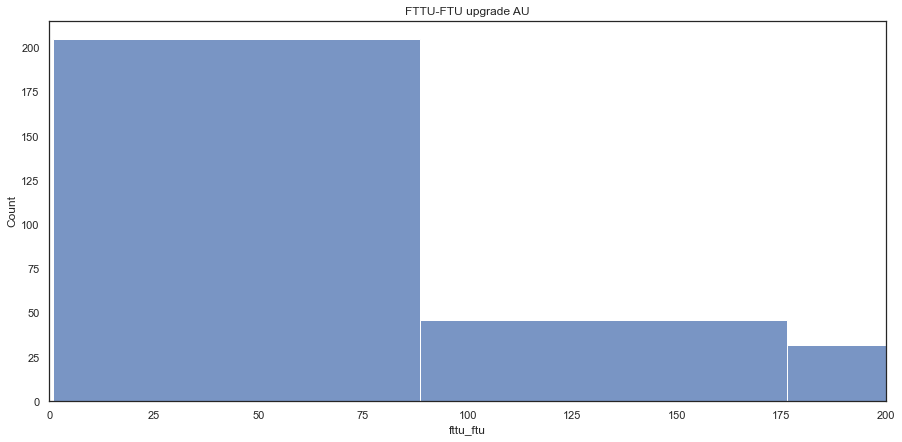

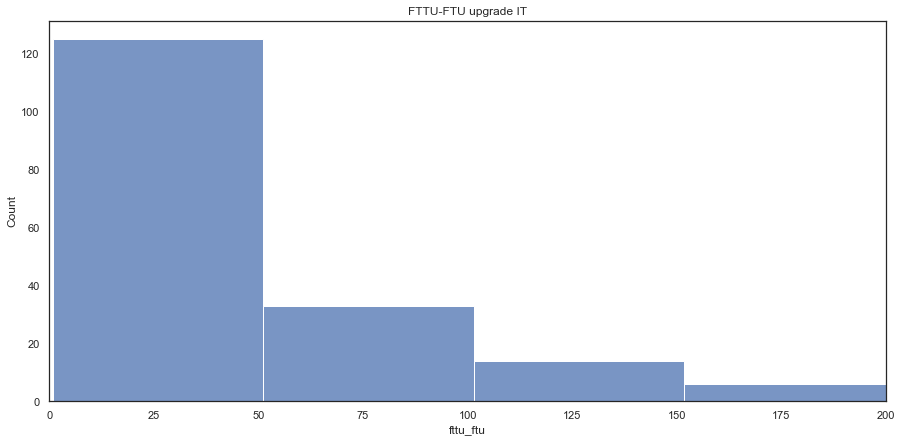

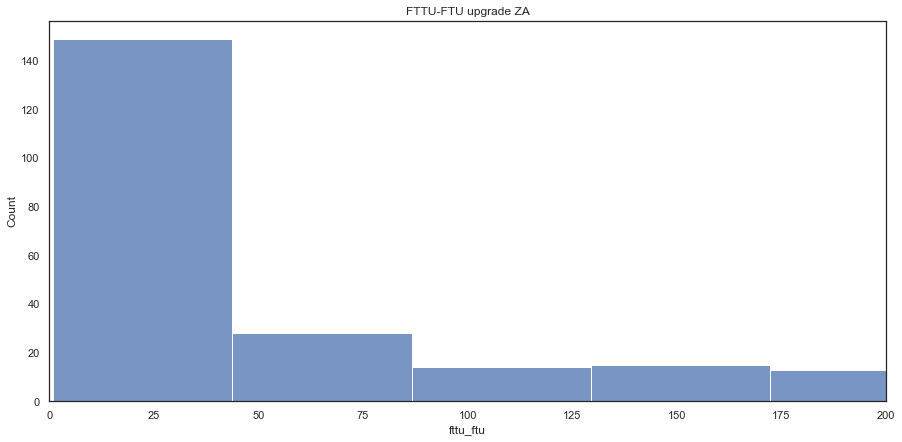

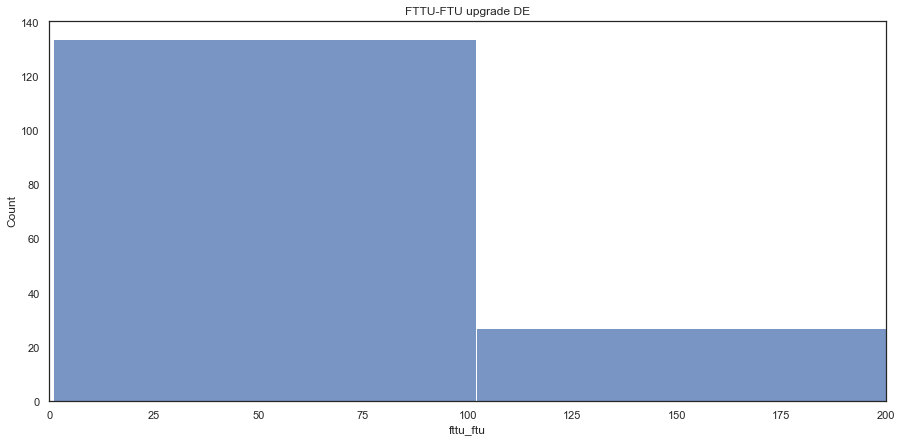

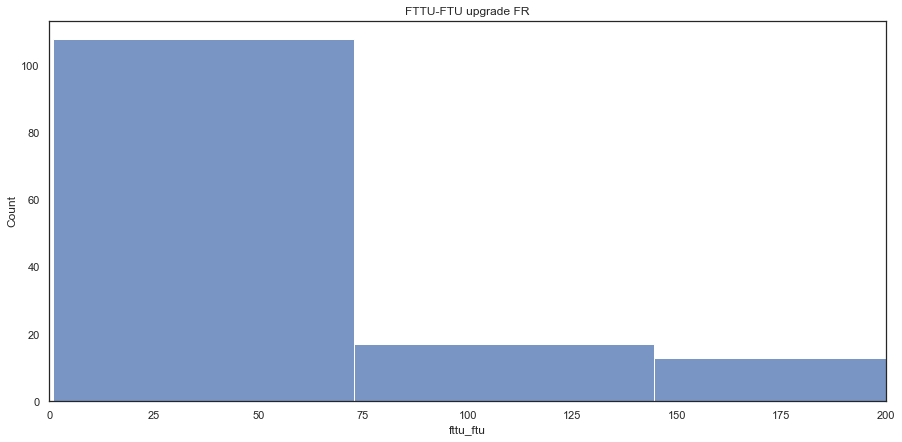

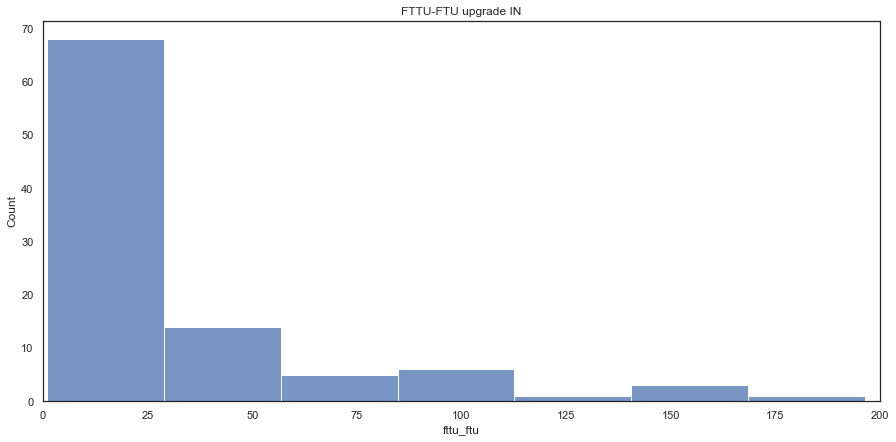

In [59]:
df_country(fttu_ftu_upgrade,'fttu_ftu', 'FTTU-FTU upgrade' )

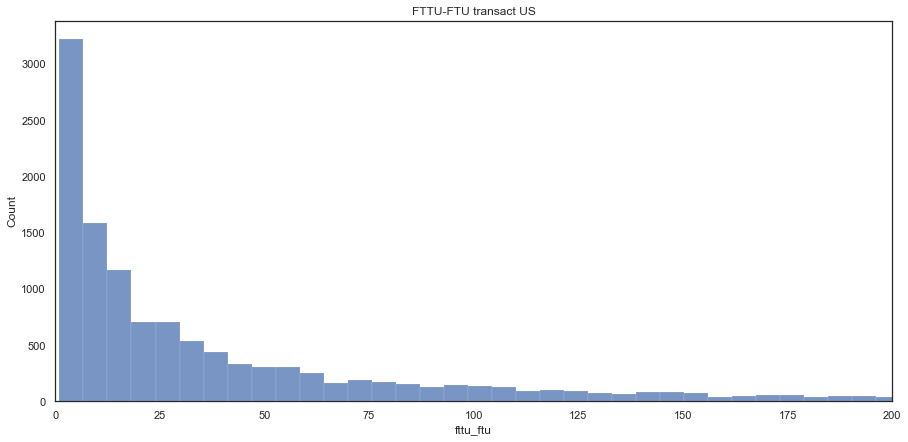

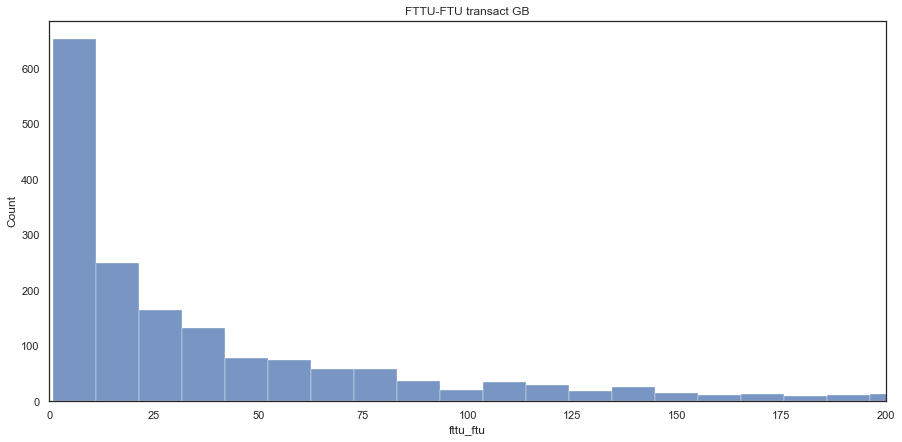

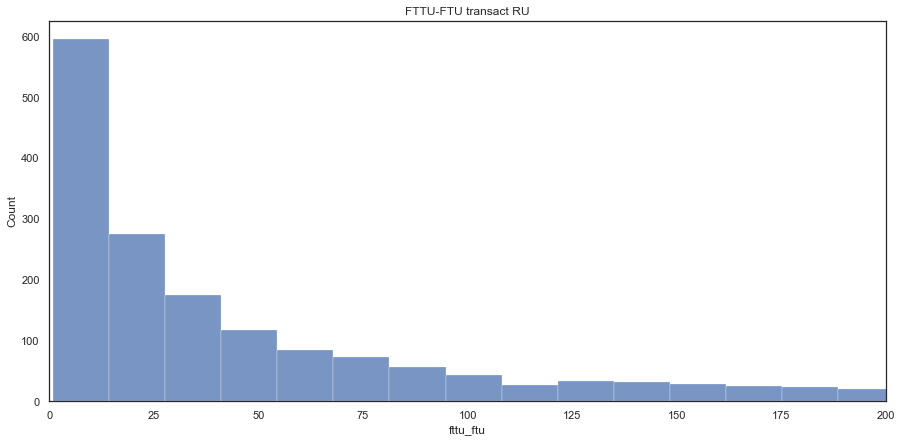

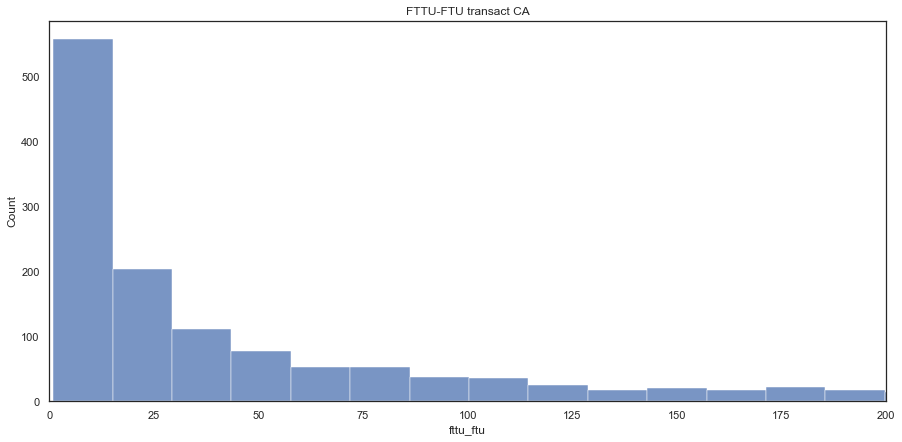

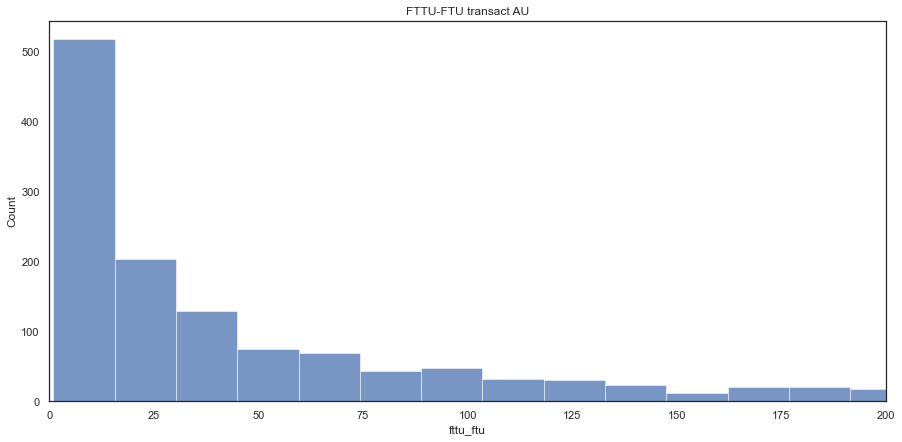

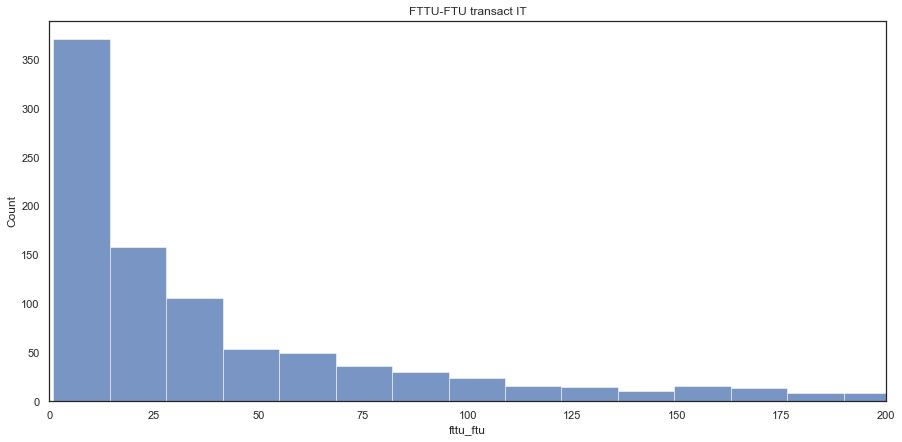

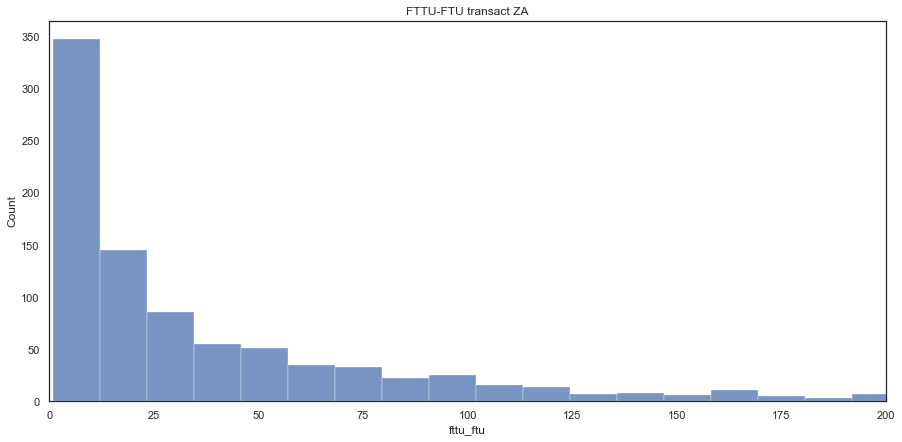

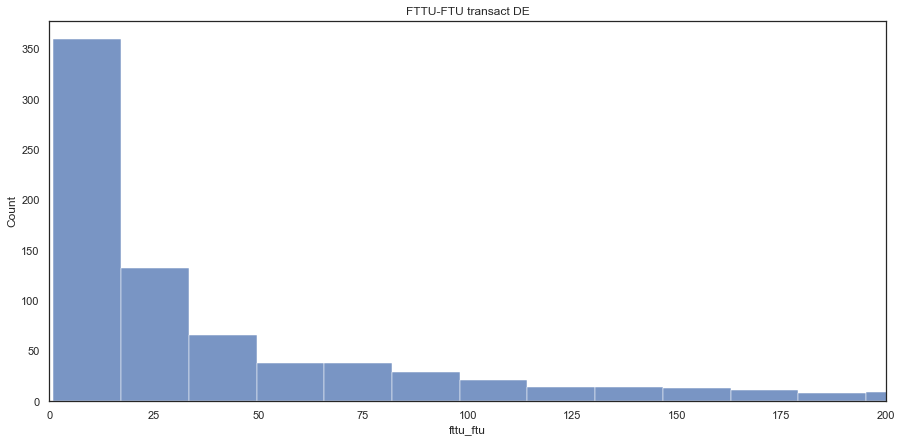

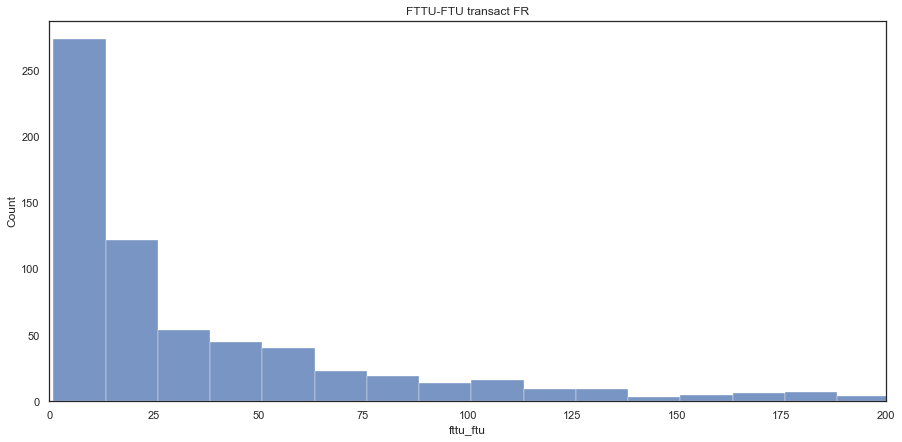

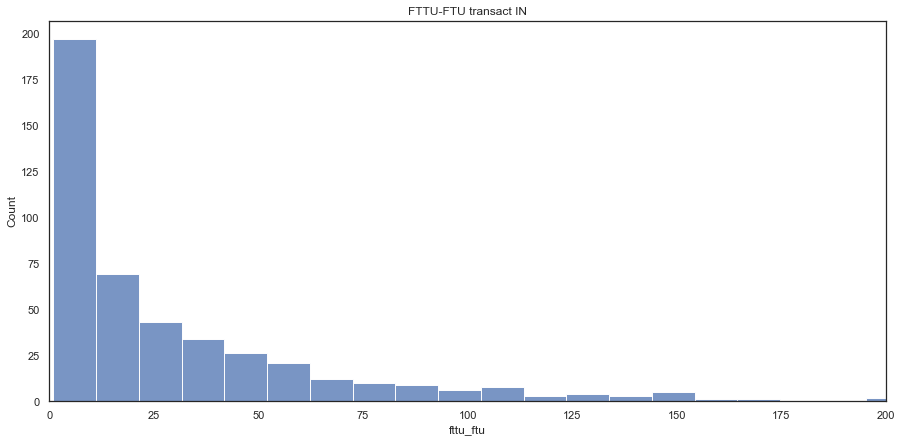

In [60]:
df_country(fttu_ftu_transact,'fttu_ftu', 'FTTU-FTU transact' )

In [17]:
country_df(fttu_ftu_upgrade, 'fttu_ftu', 'FTTU-ftu upgrade' )

In [18]:
country_df(fttu_ftu_transact, 'fttu_ftu', 'FTTU-FTU transact')

### Категоризация FTTU-FTU

In [ ]:
fttu_ftu_upgrade_cat = category(fttu_ftu_upgrade,'fttu_ftu_categorical_upgrade','fttu_ftu', 'FTTU-FTU upgrade')
fttu_ftu_upgrade_cat.head()

In [20]:
fttu_ftu_transact_cat = category(fttu_ftu_transact,'fttu_ftu_categorical_transact','fttu_ftu', 'FTTU - FTU transact')
fttu_ftu_transact_cat.head()

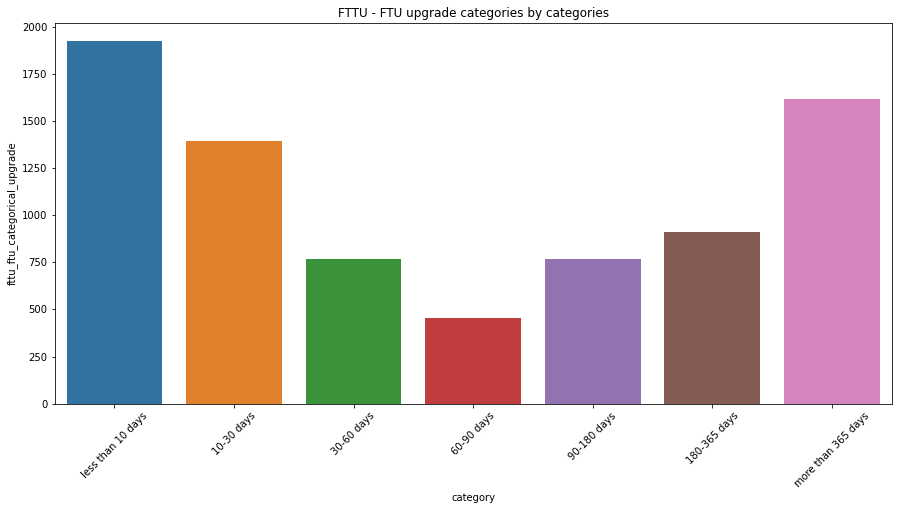

In [46]:
graphs(fttu_ftu_upgrade_cat, 'fttu_ftu_categorical_upgrade', 'FTTU - FTU upgrade categories')

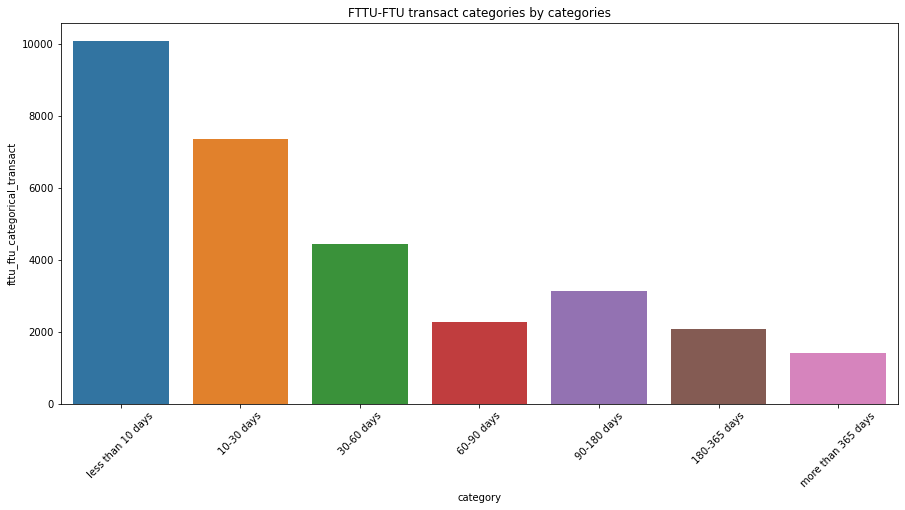

In [47]:
graphs(fttu_ftu_transact_cat, 'fttu_ftu_categorical_transact', 'FTTU-FTU transact categories')

## Часть 3. FTU-registration

In [48]:
print('Среднее количество дней по ftu - reg', round(df['ftu_reg'].mean()), 'дней')
print()
print('Медиана дней по ftu - reg', round(df['ftu_reg'].median()), 'дней')

Среднее количество дней по ftu - reg 108 дней

Медиана дней по ftu - reg 6 дней


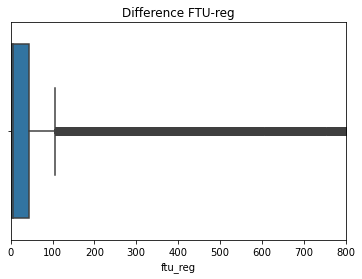

In [49]:
boxplots_before(df, 'ftu_reg', 'FTU-reg')

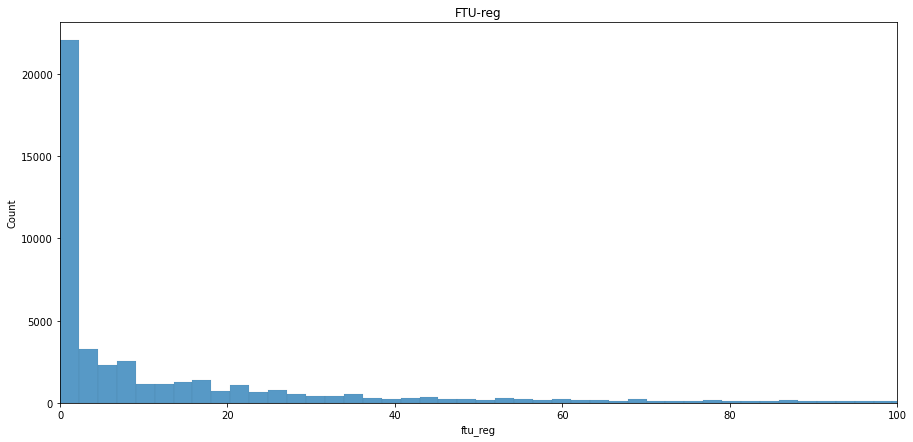

In [50]:
hists(df, 'ftu_reg', 'FTU-reg')

### FTU-registration по странам

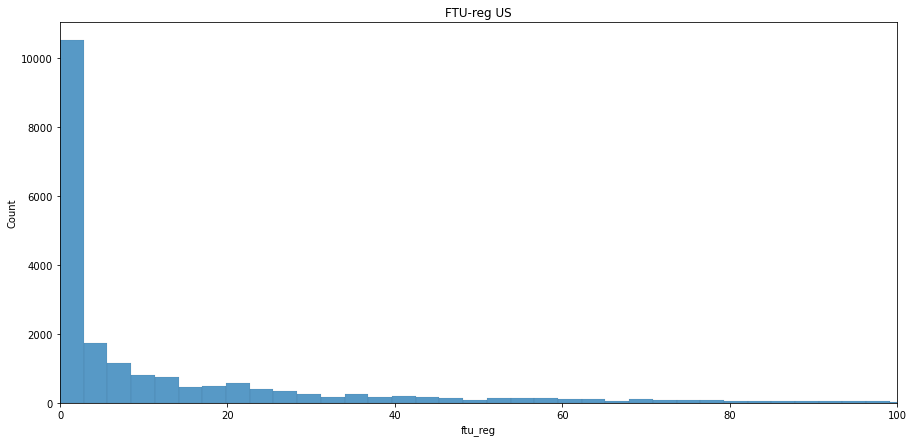

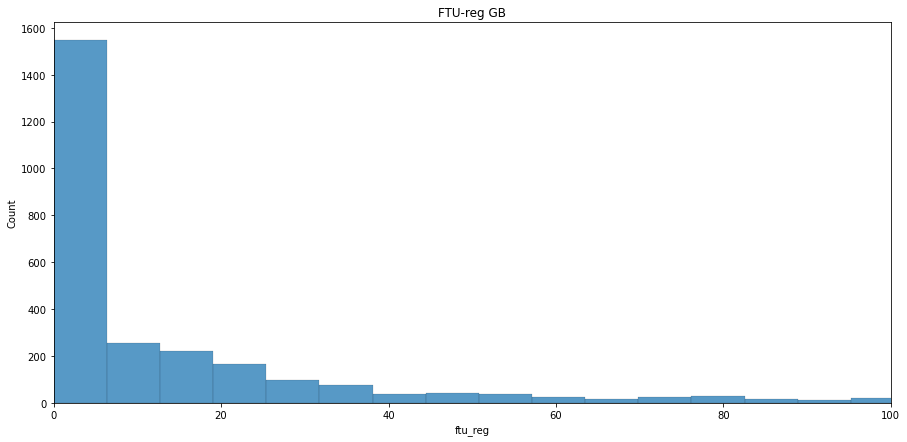

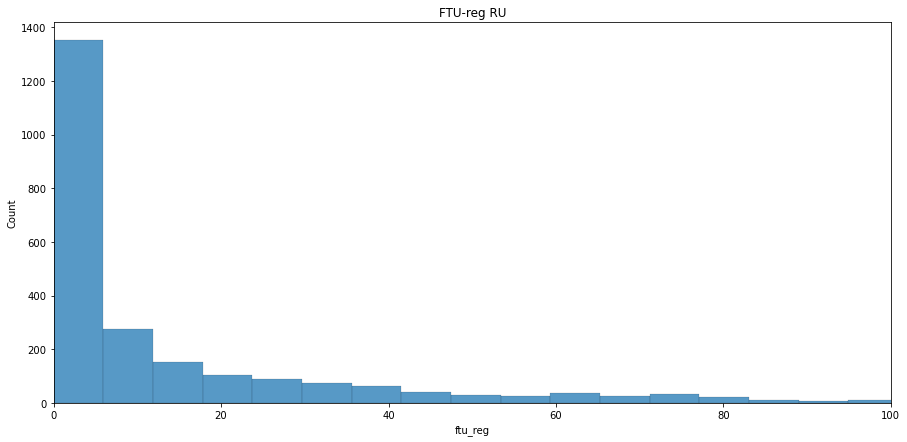

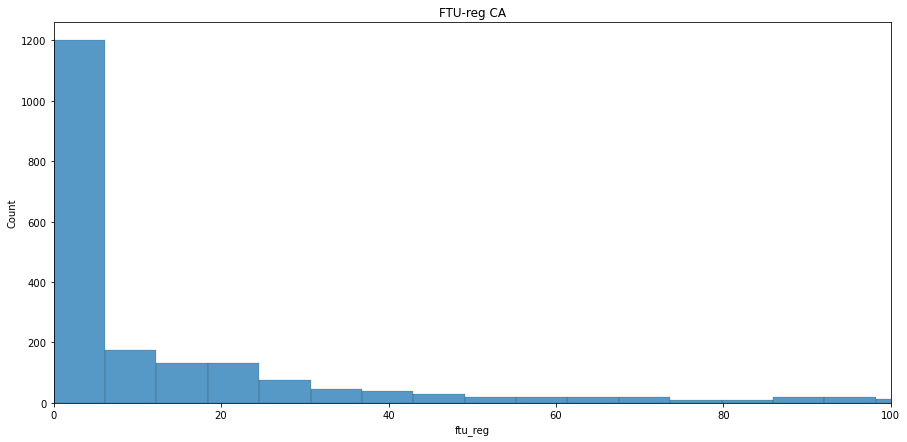

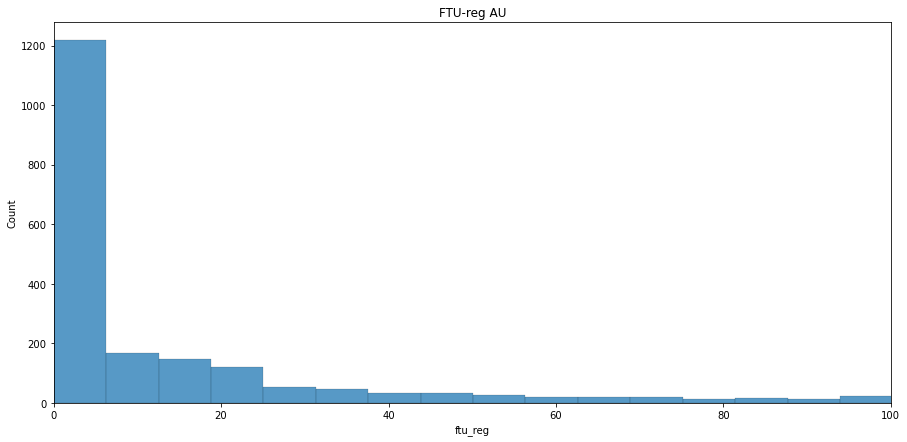

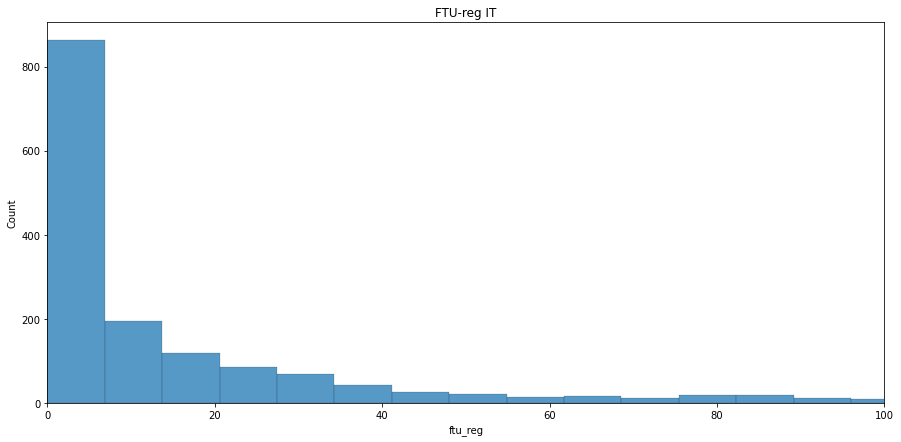

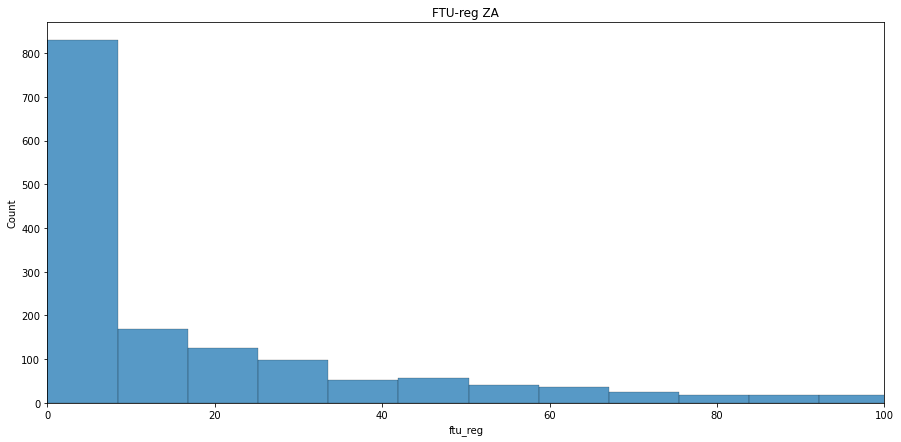

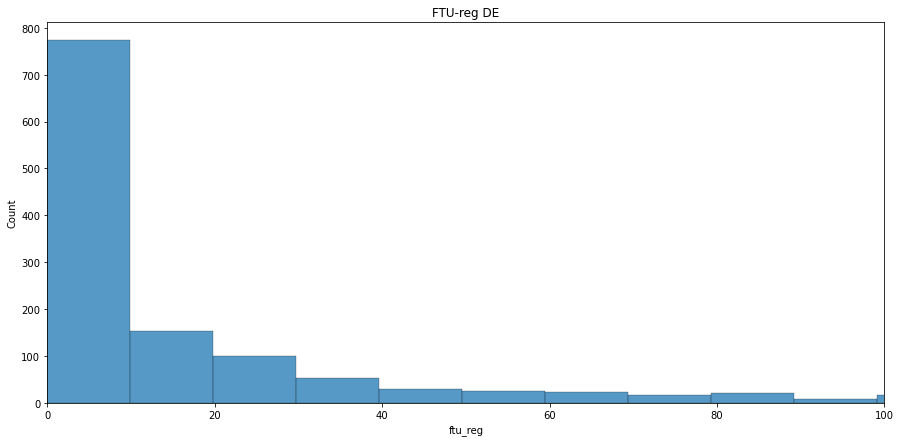

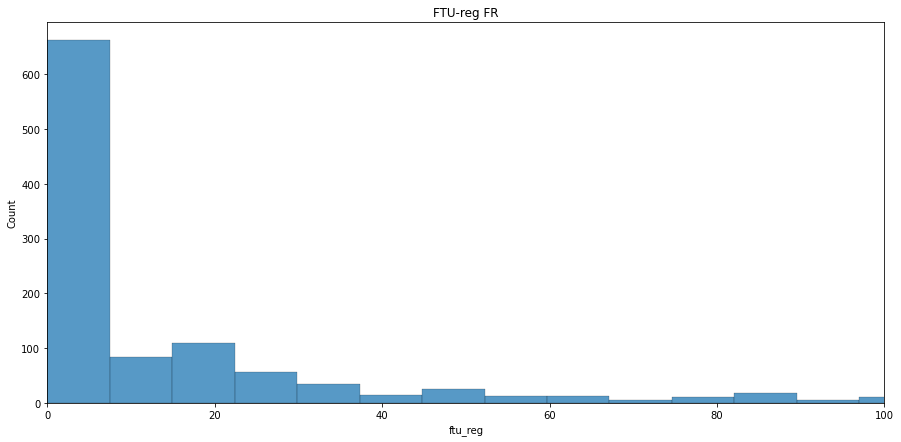

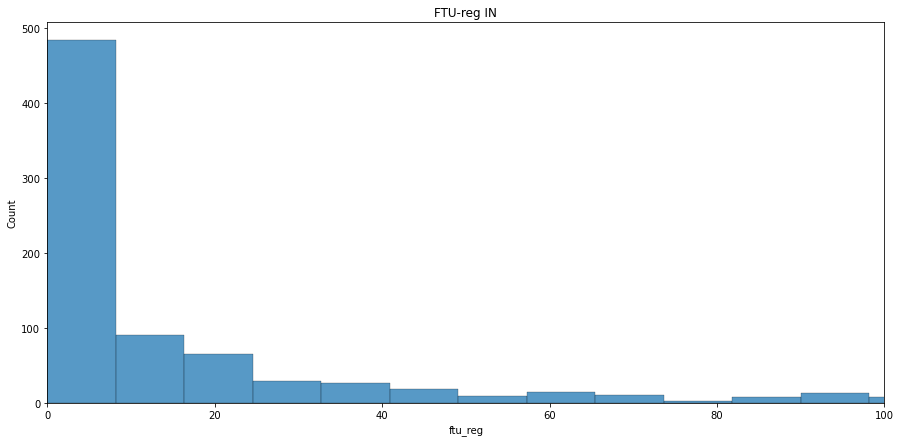

In [51]:
df_country(df,'ftu_reg', 'FTU-reg' )

In [21]:
country_df(df, 'ftu_reg', 'FTU-reg')

### Категоризация FTU-registration

In [53]:
ftu_reg_cat = category(df,'ftu_reg_categorical','ftu_reg', 'FTU - reg')

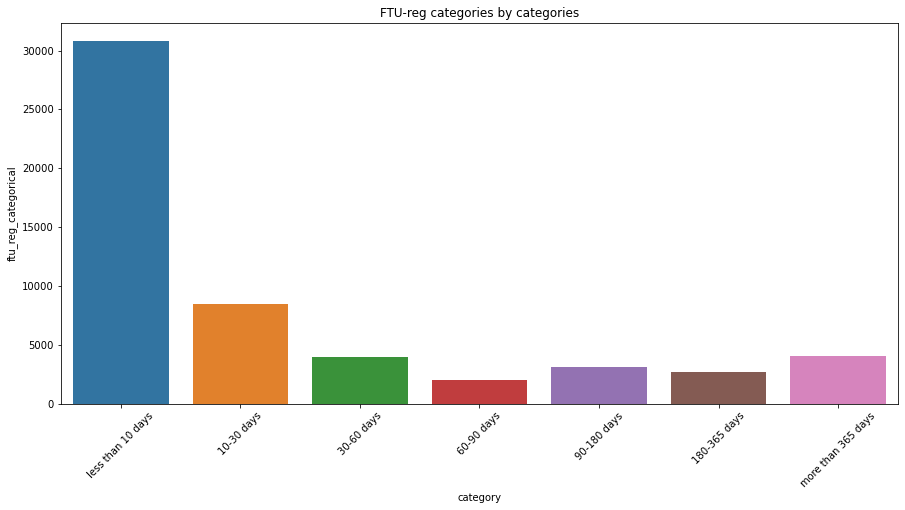

In [54]:
graphs(ftu_reg_cat, 'ftu_reg_categorical', 'FTU-reg categories')

### Часть 4. Общая часть

In [55]:
def tables_category(df, df1, x1, x2):
    df2 = df[['store_id', x1]].copy()
    df3 = df1[['store_id', x2]].copy()
    df4 = df2.merge(df3, how='left', on='store_id')
    df5 = df4.pivot_table(index=x2, \
              columns=x1, \
              values='store_id', aggfunc='nunique') 
    #return df5
    sns.set(style='white')
    plt.figure(figsize=(15, 7))
    sns.heatmap(df5, cmap=sns.cubehelix_palette(as_cmap=True))
    plt.title('Heatmap by FTTU-reg vs FTU-reg')
    plt.show()

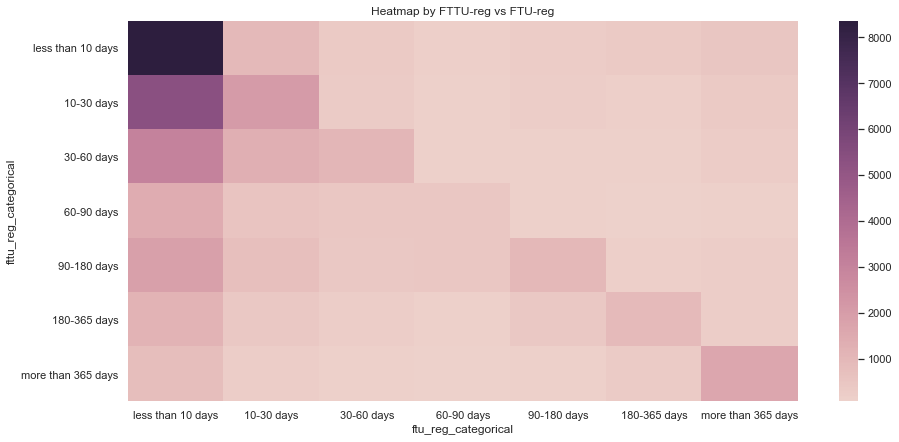

In [56]:
tables_category(ftu_reg_cat, fttu_reg_cat,'ftu_reg_categorical', 'fttu_reg_categorical' )